# Lecture 19: Bioimaging I

CBIO (CSCI) 4835/6835: Introduction to Computational Biology

## Overview and Objectives

Now that we've covered the basics of computer vision, let's look at how this can be applied in a biological setting with some in-depth examples of how to analyze biological images. By the end of this lecture, you should be able:

 - Explain convolutional filters and how they perform operations such as blurring, sharpening, and edge finding
 - Implement erosion and dilation and define them in the context of image processing
 - Provide an end-to-end example of how to segment an image (for example: count cells)

## Part 1: Filters

What does "filter" mean to you?

Instagram?

![instagram](Bioimaging1/instagram.jpg)

Photoshop?

![photoshop](Bioimaging1/photoshop.jpg)

Both are technically "yes", as they use the same underlying principle.

A filter applies a *convolution kernel* to an image.

Although this sounds fancy, this is just a generalization of a very simple idea: rather than applying a specific function to one pixel, this uses the pixel's surrounding neighborhood to apply a function.

The kernel is represented by an $n \times n$ matrix where the target pixel is in the center (so $n$ needs to be an odd number).

The output of the filter is the sum of the products of the matrix elements with the corresponding pixels they overlap.

Confused?

Here's what it looks like. The image is the bigger $5 \times 5$ matrix; the filter is the smaller $3 \times 3$ matrix:

$$
\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1
\end{bmatrix}
$$

https://github.com/eds-uga/cbio4835-fa18/blob/master/lectures/Bioimaging1/convolution.gif

### Convolutional Kernels

A convolution is basically a multiplication: the smaller matrix is multiplied element-wise with the overlapped entries of the larger matrix. These products are then all summed together into a new value for the pixel at the very center of the filter.

Then the filter is moved and the process repeats. This is true for any and all filters (or *kernels*).

What creates the specific effect, then--edge finding, blurring, sharpening, and so on--is the specific numbers in the filter. As such, there are some common filters:

![filtertypes](Bioimaging1/filtertypes.png)

[Wikipedia has a whole page](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Details) on common convolutional filters.

![filters](Bioimaging1/filters.png)

Of course, you don't have to design the filter and code up the convolution yourself (though you could!). Most image processing packages have default versions of these filters included.

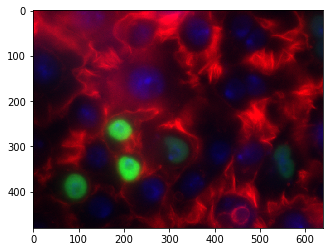

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from PIL import ImageFilter

img = Image.open("ComputerVision/image1.png")
plt.imshow(img)

Some of the PIL built-in filters include:

 - BLUR
 - CONTOUR
 - DETAIL
 - EDGE_ENHANCE
 - EDGE_ENHANCE_MORE
 - EMBOSS
 - FIND_EDGES
 - SMOOTH
 - SMOOTH_MORE
 - SHARPEN

Here's BLUR:

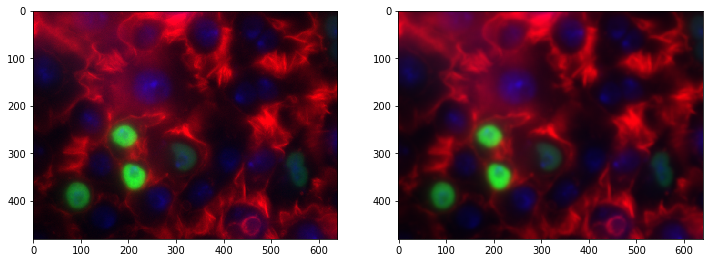

In [2]:
import numpy as np

blurred = img.filter(ImageFilter.BLUR)
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(np.array(img))
f.add_subplot(1, 2, 2)
plt.imshow(np.array(blurred))

Here's SHARPEN:

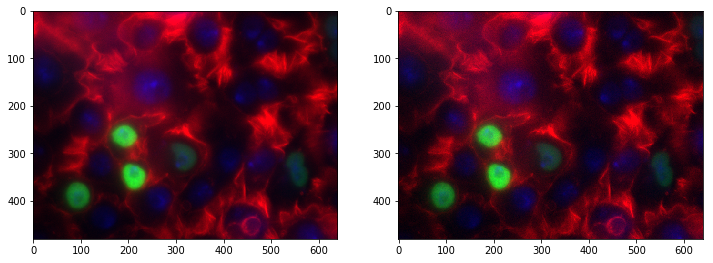

In [3]:
sharpened = img.filter(ImageFilter.SHARPEN)
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(np.array(img))
f.add_subplot(1, 2, 2)
plt.imshow(np.array(sharpened))

And FIND_EDGES (more on this later):

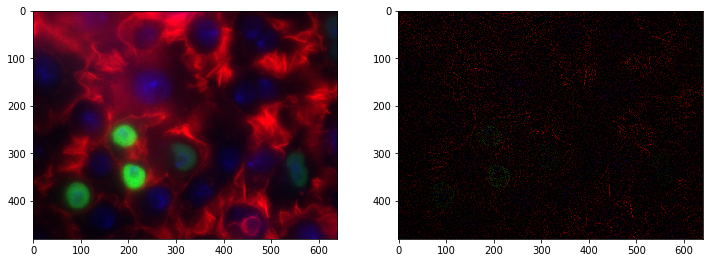

In [4]:
edges = img.filter(ImageFilter.FIND_EDGES)
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(np.array(img))
f.add_subplot(1, 2, 2)
plt.imshow(np.array(edges))

There are other filters that don't quite abide by the "multiply every corresponding element and then sum the products" rule of convolution.

In deep learning parlance, these filters are known as "pooling" operators, because while you still have a filter that slides over the image, you *choose one* of the pixel values within that filter instead of computing a function over *all the pixel values*.

As common examples, we have
 - Median filters: picking the median pixel value in the filter range
 - Max and min filters: picking the maximum (max-pool) or minimum (min-pool) pixel value in the filter range

Here's max-pooling:

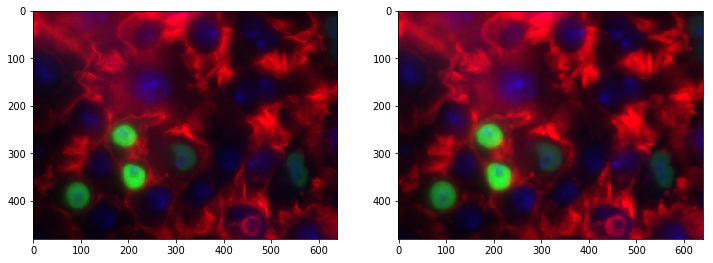

In [5]:
max_pool = img.filter(ImageFilter.MaxFilter(5))  # This means a 5x5 filter
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(np.array(img)) 
f.add_subplot(1, 2, 2)
plt.imshow(np.array(max_pool))

(just to help things, let's convert to grayscale and try that again)

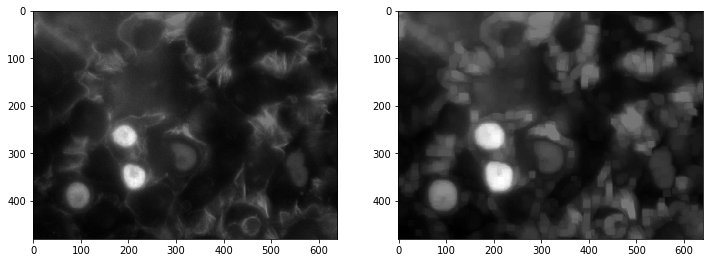

In [6]:
img = img.convert("L")

# Same code as before.
max_pool = img.filter(ImageFilter.MaxFilter(11))  # This means an 11x11 filter
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(np.array(img), cmap = "gray")
f.add_subplot(1, 2, 2)
plt.imshow(np.array(max_pool), cmap = "gray")

How about median pooling?

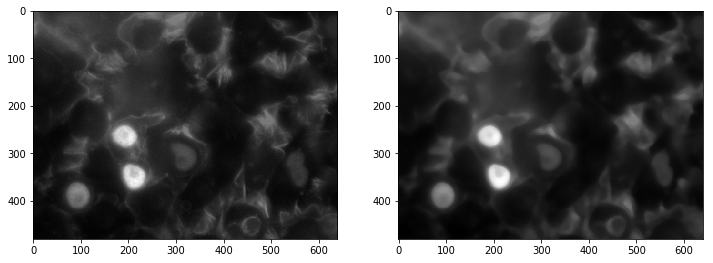

In [7]:
median_pool = img.filter(ImageFilter.MedianFilter(11))  # This means an 11x11 filter
f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(np.array(img), cmap = "gray")
f.add_subplot(1, 2, 2)
plt.imshow(np.array(median_pool), cmap = "gray")

### So...

What are the benefits of filtering and pooling? Why would something like a blur filter or a median filter be nice to use?

**These filters clear out a lot of noise**.

 -  By considering neighborhoods of pixels, you're able to automatically dampen tiny flecks of fluorescence that don't correspond to anything, because they'll be surrounded by black.

 - On the other hand, filters like blur and median won't [strongly] affect large sources of fluorescence, since the neighborhoods of any given pixel will also be emitting lots of signal.

**Protip**: median filters are awesome for getting rid of tiny little specks of light you don't want, while maintaining sharp edges between objects (unlike Gaussian blur filters).

## Part 2: Edges

Edge-finding is an important aspect of bioimaging and image processing in general.

Edges essentially denote "image derivatives" (and are essentially calculated as such!). Edges are formed by the image pixels changing suddenly.

Edges delineate objects. The question isn't necessarily where the edges of the object are, but *which* edges belong to the object you're interested in.

### Canny Edge Detector

One of the most popular algorithms for finding edges in an image is the *Canny Edge Detector*.

The Canny edge detector works in three distinct phases (don't worry, you won't have to implement any of these):

1: It runs a filter (!) over the image, using the Gaussian formulation, to generate a filtered image. However, this Gaussian filter is a special variant--it actually represents the *first derivative* of a Gaussian. Running this filter over the image *essentially* computes the image derivatives at each pixel.

2: The filter generates a lot of "candidate" edges that have to be pruned down; the edges are reduced until they're only 1 pixel thick.

3: Finally, a threshold is applied: a pixel is considered part of an "edge" if its derivative (as computed in step 1) exceeds a certain value. The higher the threshold, the larger the pixel derivative has to be to be considered an edge.

In action, Canny edge detectors looks something like this:

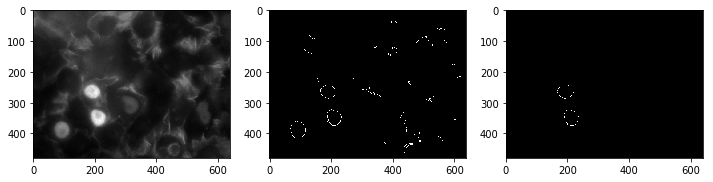

In [8]:
import skimage.feature as feature

img = np.array(img)
canny_small = feature.canny(img, sigma = 1)
canny_large = feature.canny(img, sigma = 3)

f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 3, 1)
plt.imshow(img, cmap = "gray")
f.add_subplot(1, 3, 2)
plt.imshow(canny_small, cmap = "gray")
f.add_subplot(1, 3, 3)
plt.imshow(canny_large, cmap = "gray")

 - Note how many fewer edges there are with `sigma = 3` than `sigma = 1`.
 - By making this sigma larger, you're upweighting neighboring pixels in the Gaussian derivative filter.
 - This makes it harder for the middle pixel (the one under consideration as an edge, or not) to exceed the "threshold" from step 3 to be considered an edge.
 - The `sigma` argument essentially equates to the "width" of the filter--smaller width, smaller neighborhood; therefore, more representation by the middle pixel.

### Erosion and Dilation

Another common noise-reducing step is some combination of *erosion* and *dilation*.

These don't find edges per se, but rather they modify the edges.

Erosion will move along objects and erode them by 1 pixel (or more).

![erosion](Bioimaging1/erosion.png)

This has the benefit of utterly wiping out objects that are very small--these are usually noise anyway.

Dilation is the inverse operation: it will move along objects, padding their edges by 1 pixel (or more).

![dilation](Bioimaging1/dilation.png)

This has the effect of smoothing object edges--jagged edges are filled in.

These two effects are often used in tandem to smooth out potentially rough images.

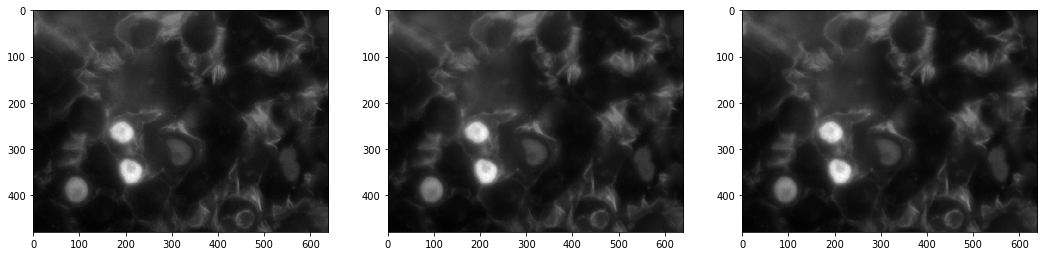

In [9]:
import skimage.morphology as morphology

de1 = morphology.dilation(morphology.erosion(img))
de2 = morphology.dilation(morphology.erosion(de1))

f = plt.figure(figsize = (18, 9))
f.add_subplot(1, 3, 1)
plt.imshow(img, cmap = "gray")
f.add_subplot(1, 3, 2)
plt.imshow(de1, cmap = "gray")
f.add_subplot(1, 3, 3)
plt.imshow(de2, cmap = "gray")

Hmm, not an obvious effect in the full grayscale.

Let's try again, taking a page from yesterday's lecture--specifically, let's use a single channel and threshold the image.

In [10]:
import scipy.ndimage as ndimg

img = ndimg.imread("ComputerVision/image1.png")
hsp = img[:, :, 1]  # Green channel - heat shock protein
hsp_bin = hsp > np.mean(hsp)  # Median threshold.

/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


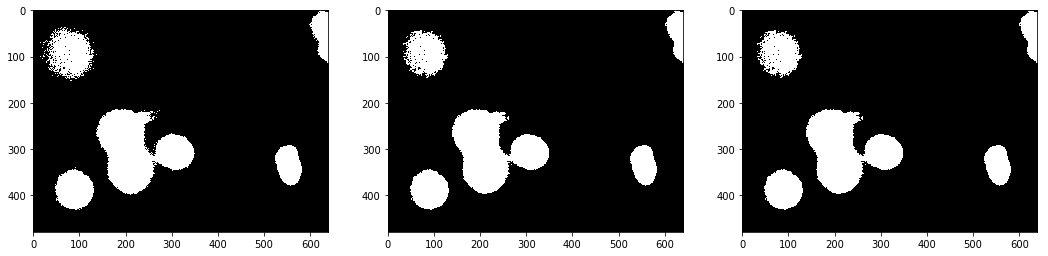

In [11]:
# Now we'll do the same code as before.
de1 = morphology.binary_dilation(morphology.binary_erosion(hsp_bin))
de2 = morphology.binary_dilation(morphology.binary_erosion(de1))

f = plt.figure(figsize = (18, 9))
f.add_subplot(1, 3, 1)
plt.imshow(hsp_bin, cmap = "gray")
f.add_subplot(1, 3, 2)
plt.imshow(de1, cmap = "gray")
f.add_subplot(1, 3, 3)
plt.imshow(de2, cmap = "gray")

### Skeletonization

You can go a step further. If you're not interested in the overall *shape* of the objects, but just want some measure of how many and where, you can use skeletonization.

This essentially performs the erosion operation over and over until each object is only 1 pixel wide.

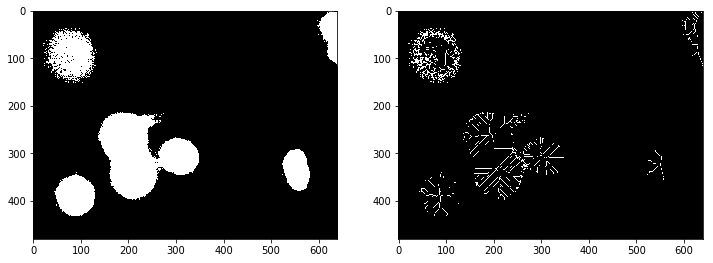

In [12]:
skeleton = morphology.skeletonize(hsp_bin)

f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(hsp_bin, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.imshow(skeleton, cmap = "gray")

What went wrong, do you think? Why didn't we just get 1-2 lines per object?

We should try to eliminate all those specks!

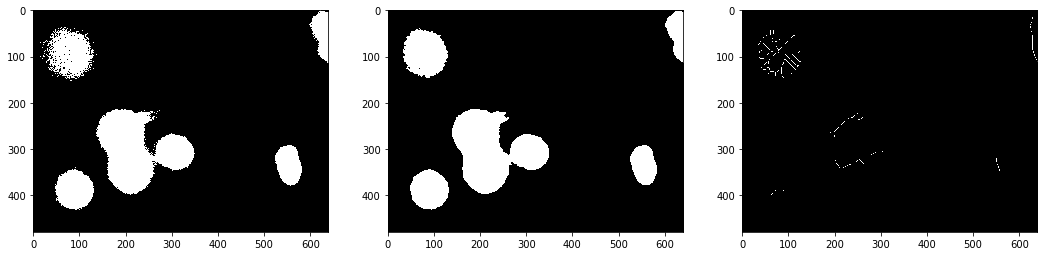

In [13]:
import skimage.filters as filters

bin_median = filters.median(hsp_bin, morphology.square(5))
bin_median[bin_median == 255] = 1
skeleton = morphology.skeletonize(bin_median)

f = plt.figure(figsize = (18, 9))
f.add_subplot(1, 3, 1)
plt.imshow(hsp_bin, cmap = "gray")
f.add_subplot(1, 3, 2)
plt.imshow(bin_median, cmap = "gray")
f.add_subplot(1, 3, 3)
plt.imshow(skeleton, cmap = "gray")

### Convex Hull

The inverse operation of skeletonization is the to find the *convex hull* of objects in the image. This is basically a fancy way of saying:

 - Draw the simplest $n$-gon you can to encompass the entire object.

This is a very good way of deriving *masks* for complex!

Let's give ourselves a bit of a head start by using that binarized median filtered image:

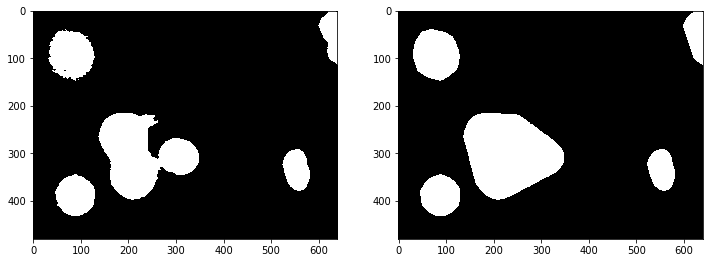

In [14]:
convex_hulls = morphology.convex_hull_object(bin_median)

f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(bin_median, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.imshow(convex_hulls, cmap = "gray")

We can overlay the two plots to show how the convex hulls were drawn:

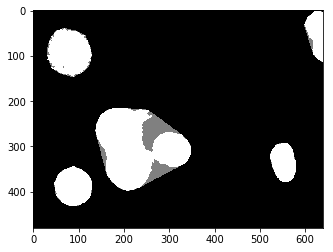

In [15]:
import skimage
img_float = skimage.img_as_float(convex_hulls.copy())
img_float[bin_median == 1] = 2

plt.imshow(img_float, cmap = "gray")

## Part 3: Segmentation

Ok--we've seen so far how to identify objects (kinda) in images. It'd be great to actually get their coordinates, extract them, and learn something about their shape and size and general morphology.

This is the process of *segmentation*: explicitly developing a mask that pulls out the objects you're interested in.

The convex hulls are a good start, but that one blob near the middle combined a bunch of the cells.

(yes, we're purposely hobbling ourselves by not using the DAPI channel; for illustration purposes)

We can employ a specific segmentation to try and break that blob apart into multiple objects, ideally correpsonding with the blobs we see in the grayscale image.

### Watershed Segmentation

This starts with the idea of treating your image as a contour map, where pixel intensity indicates elevation.

![watershed](Bioimaging1/watershed.png)

From the "lowest" parts of your image, you start filling your image with water.

Where water from each "basin" meets, that's a segmentation boundary.

Continue raising the water level of your image until you have fully segmented it.

This will give you an image with boundaries between all the objects.

![boundaries](Bioimaging1/watershed_sample_boundaries.png)

"Wait a minute," you start, "that looks great and all, but how do you know where to start adding the water?"

Excellent question. Ideally, we'd like to place a "basin" (or "seed") inside each object. But that requires knowing where the objects are ahead of time, which kind of obviates the need for watershed in the first place.

Well, I kinda gave it away earlier--we're looking for pixels that have values at the extremes. These are known as *local maxima*.

We'd like to think that each object has a "center" that is bright; ideally, it's the brightest part of the object.

This isn't always the case, but we can kind of force it using a *distance map*. If we compute the distance of any point inside an object to its edge, the center should be the farthest, right?

### Distance Maps

Let's first see about computing the distance map for our binarized median filtered image.

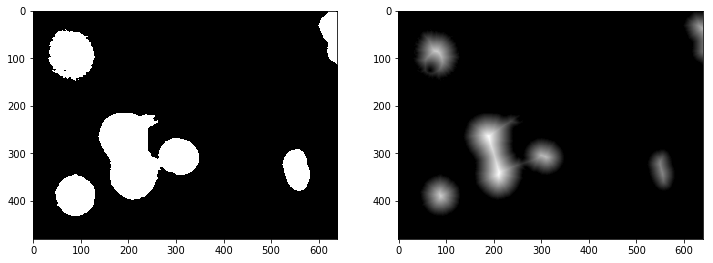

In [16]:
distmap = ndimg.distance_transform_edt(bin_median)

f = plt.figure(figsize = (12, 6))
f.add_subplot(1, 2, 1)
plt.imshow(bin_median, cmap = "gray")
f.add_subplot(1, 2, 2)
plt.imshow(distmap, cmap = "gray")

(yep, you could probably use skeletonization to achieve the same effect!)

Now, we'll find the coordinates of the local maxima and use those as seeds for watershed.

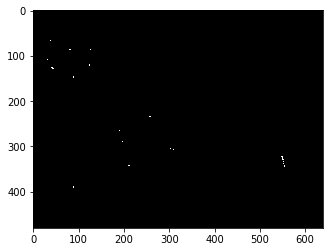

In [17]:
maxima = feature.peak_local_max(distmap, indices = False, min_distance = 2, labels = bin_median)
display = morphology.dilation(maxima)

plt.imshow(display, cmap = "gray")

Now we'll use these coordinates as our starting points for watershed!

/opt/python/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


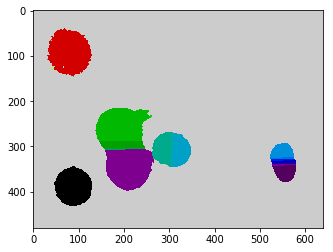

In [18]:
markers = ndimg.label(maxima)[0]
labels = morphology.watershed(-distmap, markers, mask = bin_median)

plt.imshow(labels, cmap = "nipy_spectral_r")

It's certainly not perfect.

There are a lot of improvements that could be made, but this was just to illustrate how to get segmented regions.

Once you have these regions, you can ask a lot of interesting questions about them:

In [19]:
import skimage.measure as measure

regions = measure.regionprops(labels)
print(len(regions))  # 28 regions, each with some of the following properties:

28


7601


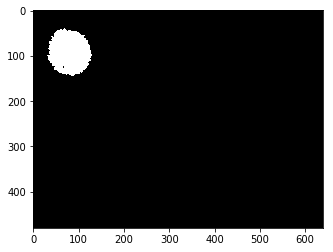

In [20]:
region1 = labels.copy()
region1[region1 != regions[1].label] = 0
plt.imshow(region1, cmap = "gray")

print(regions[1].area)

In [21]:
print(regions[1].centroid)

(92.7910801210367, 79.78897513485067)


In [22]:
print(regions[1].major_axis_length)
print(regions[1].minor_axis_length)

104.25411574839266
93.36852033227642


/opt/python/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/opt/python/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [23]:
print(regions[1].solidity)

0.9332105586249233


## Review

In this lecture, we looked at some of the most common operations in bioimaging: edge detection, blurring/sharpening, and object finding and segmentation.

Most of this is done through the use of _convolutional filters_, though there are other ways, too.

Once you've found objects and generated masks, you can compute a lot of interesting properties about them (centroid, area, major and minor axis lengths).

**All of this is in the `scikit-image` package.** This is a well-designed, well-documented, easy-to-use imaging package in Python that comes automatically installed in any Anaconda Python version.

**Next week, we'll wrap up imaging by going over OpenCV, the beast of computer vision!**

## Administrivia

 - Has anyone started Assignment 5 yet? The earlier, the better!

 - Any questions about the project?

## Additional Resources



 - scikit-image [edge detection](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html#sphx-glr-auto-examples-edges-plot-canny-py)
 - scikit-image [segmentation](http://scikit-image.org/docs/stable/auto_examples/xx_applications/plot_coins_segmentation.html#sphx-glr-auto-examples-xx-applications-plot-coins-segmentation-py)
 - scikit-image [labeling](http://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py )
 - scikit-image [regionprops](http://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html#sphx-glr-auto-examples-segmentation-plot-regionprops-py)